In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Abrindo o arquivo CSV
dados = pd.read_csv('cotas.csv', index_col=0, parse_dates=True, sep=';')
dados

,14300000,14550000,14845000,14990000
Data,,,,
1985-01-01,842.0,196.0,253.0,2169.0
1985-01-02,822.0,165.0,252.0,2178.0
1985-01-03,798.0,202.0,252.0,2186.0
1985-01-04,751.0,157.0,249.0,2194.0
1985-01-05,709.0,197.0,245.0,2201.0
...,...,...,...,...
2023-12-27,553.0,144.0,345.0,1807.0
2023-12-28,543.0,142.0,345.0,1822.0
2023-12-29,678.0,140.0,345.0,1834.0


In [3]:
# Separando os dados em treino e teste
# Treino: até 31 de dezembro de 2014
treino = dados[:'2014-12-31']
teste = dados['2015-01-01':]

In [4]:
def max_min_year(series):
  max_year = []
  min_year = []
  first_year =  series.index[0].year
  last_year = series.index[-1].year

  for i in range(first_year,last_year+1):
    aux = series[str(i)+'-01-01':str(i)+'-12-31']
    max_year.append(aux.idxmax())
    min_year.append(aux.idxmin())

  return max_year,min_year

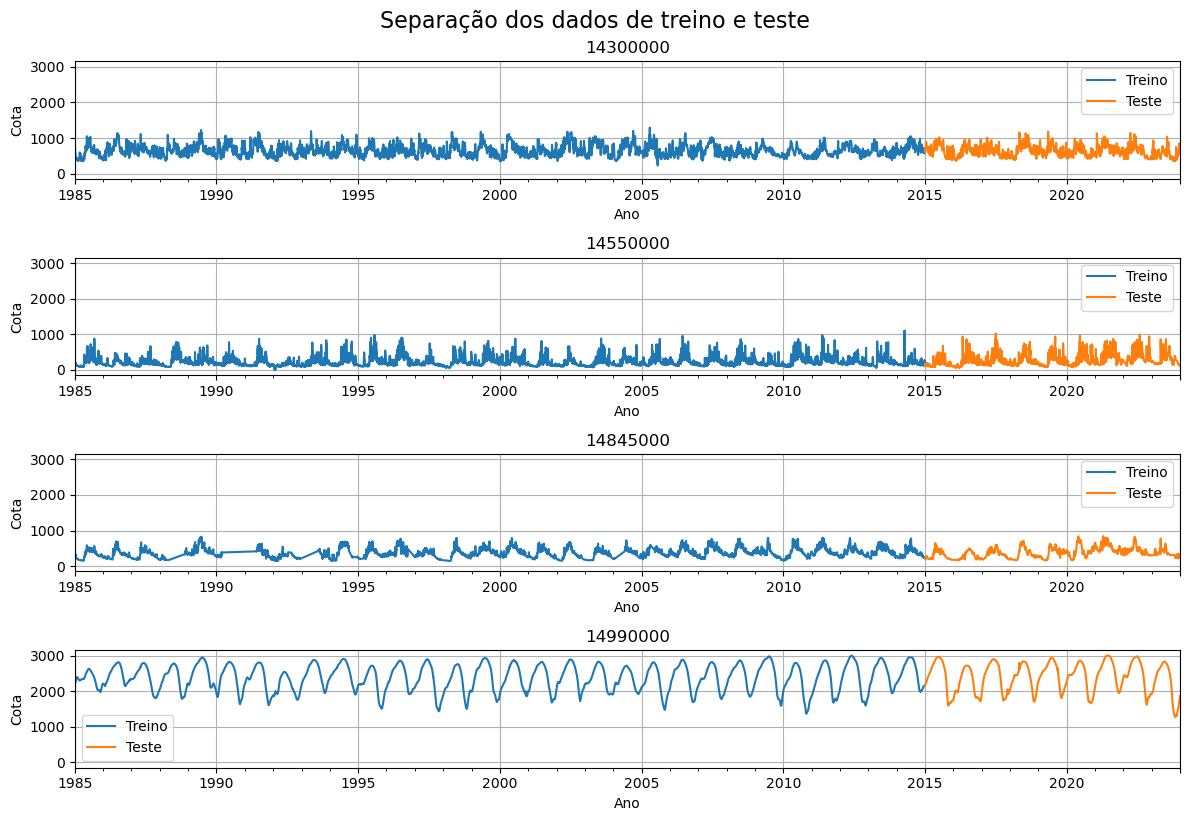

In [5]:
# Plotando os dados de treino e teste

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharey=True)
fig.subplots_adjust(hspace=1)
ax = ax.ravel()

for i, col in enumerate(dados):
    treino[col].plot(ax=ax[i], label='Treino')
    teste[col].plot(ax=ax[i], label='Teste')
    ax[i].set_title(col)
    ax[i].set_ylabel('Cota')
    ax[i].set_xlabel('Ano')
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.suptitle('Separação dos dados de treino e teste', fontsize=16, y=1.02)
plt.show()

### Funções

In [6]:
# Função para treinar o modelo

def treinar_modelo(modelo, treino, teste):
    # Criação de batches
    window_length = 365
    shifts = np.arange(1,window_length+1)
    # Create a dictionary of time-shifted data
    x_shifts = {'lag_{}'.format(ii): treino.shift(ii) for ii in shifts}
    # Convert the shifts into a dataframe
    x_shifts = pd.DataFrame(x_shifts)
    x_shifts.fillna(0, inplace=True)

    # Loop de Treinamento
    modelo.fit(x_shifts, treino)

    test_predictions = []
    first_eval_batch = treino[-window_length:].values
    current_batch = first_eval_batch.reshape((1, window_length))

    for i in range(len(teste)):
        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = modelo.predict(current_batch)[0]
        # store prediction
        test_predictions.append(current_pred)
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)
    return test_predictions

In [7]:

# def treinar_modelo(modelo, treino, teste):
#     tr = treino.values
#     te = teste.values
#     window = 365

#     history = [[tr[i] for i in range(window)]]
#     for i in range(window+1, len(tr)):
#         history.append([tr[i-j] for j in range(window, 0, -1)])

#     y = [[tr[i] for i in range(-window, 0)]]
#     count = window-1
#     count2 = 1
#     while count2 <= window:
#         y.append([tr[i] for i in range(-count, 0)] + [te[i] for i in range(count2)])
#         count -= 1
#         count2 += 1

#     for i in range(window+1, len(te)):
#         y.append([te[i-j] for j in range(window, 0, -1)])
    
#     modelo.fit(history, treino[window:])

#     predicoes = []

#     for i in range(len(y)):
#         pred = modelo.predict([y[i]])[0]
#         predicoes.append(pred)

#     return predicoes

In [8]:
# Função para plotar os resultados

def plot_resultado(resultado, teste):
    y_pred = pd.DataFrame(resultado)
    y_pred.index = teste.index

    r2 = r2_score(teste, y_pred)
    mse = mean_squared_error(teste, y_pred)
    rmse = root_mean_squared_error(teste, y_pred)
    mae = mean_absolute_error(teste, y_pred)

    print(f'R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    plt.figure(figsize=(16, 2))
    plt.plot(teste, label='Teste')
    plt.plot(y_pred, label='Predição')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.title(f'Predição de Cotas - Estação {teste.name}')
    plt.xlabel('Ano')
    plt.ylabel('Cota (cm)')
    plt.legend()
    plt.show()

### MLP

In [19]:
mlp = MLPRegressor(hidden_layer_sizes=(11, 11), max_iter=1000, learning_rate_init=0.004)

R²: -0.6190, MSE: 41511.1450, RMSE: 203.7428, MAE: 158.9231


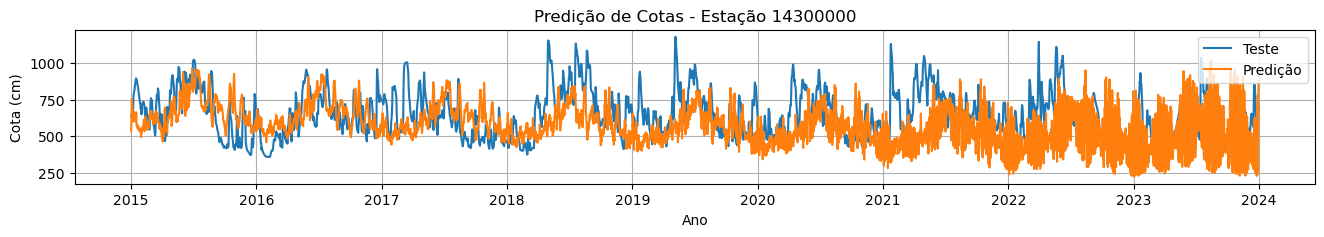

R²: -0.1376, MSE: 28379.9846, RMSE: 168.4636, MAE: 111.8132


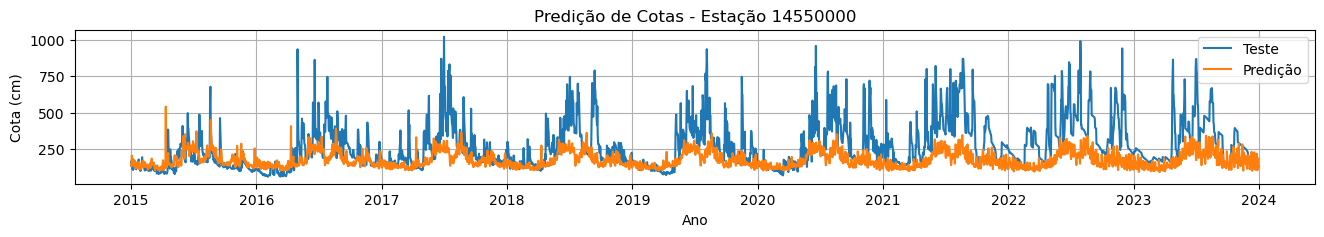

R²: 0.2404, MSE: 16252.3209, RMSE: 127.4846, MAE: 97.3507


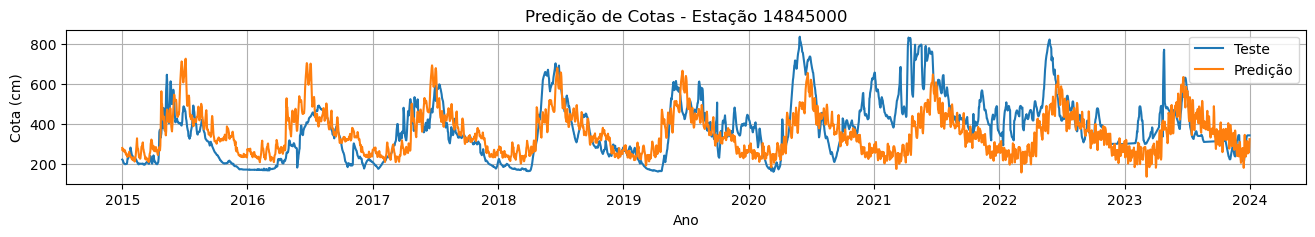

R²: 0.6647, MSE: 59444.9481, RMSE: 243.8133, MAE: 190.0606


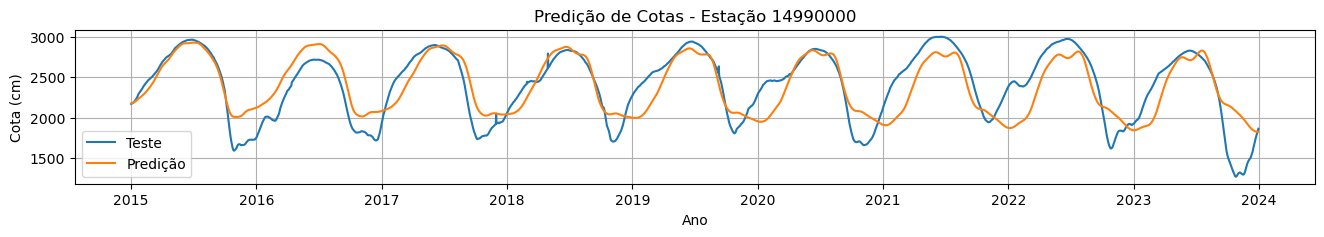

In [20]:
for i, col in enumerate(dados):
    resultado = treinar_modelo(mlp, treino[col], teste[col])
    plot_resultado(resultado, teste[col])

### Random Forest

In [11]:
rf = RandomForestRegressor(n_jobs=-1)

R²: -0.3345, MSE: 34215.7676, RMSE: 184.9750, MAE: 150.6943


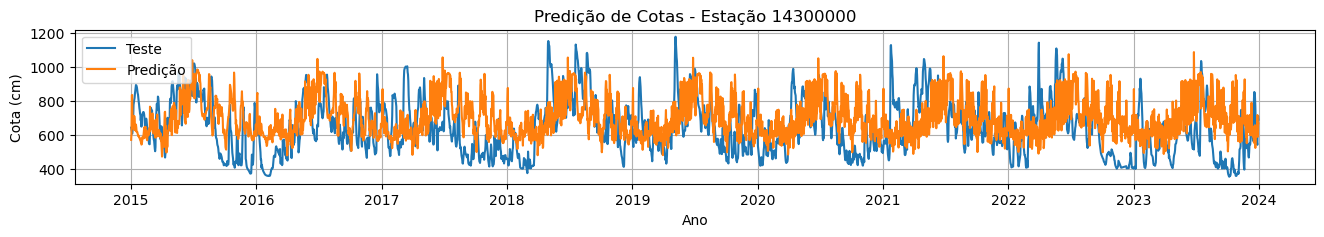

R²: -0.3377, MSE: 33369.3526, RMSE: 182.6728, MAE: 122.9619


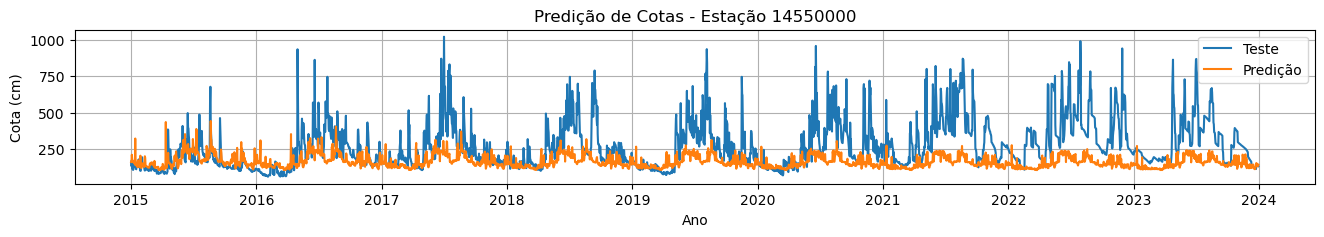

R²: 0.2245, MSE: 16593.4365, RMSE: 128.8155, MAE: 99.5080


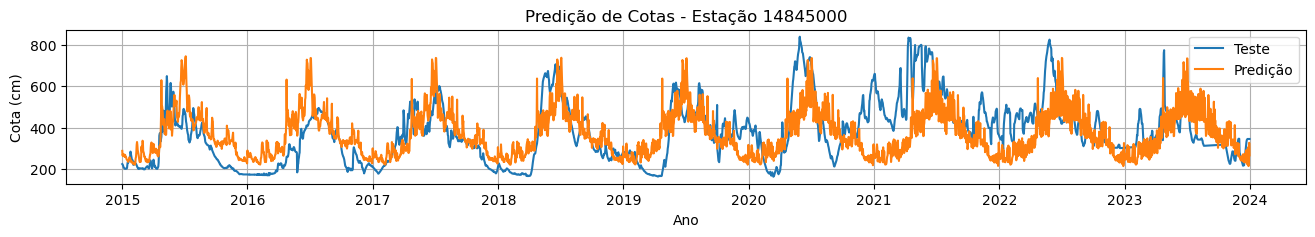

R²: 0.7165, MSE: 50263.2023, RMSE: 224.1946, MAE: 164.3461


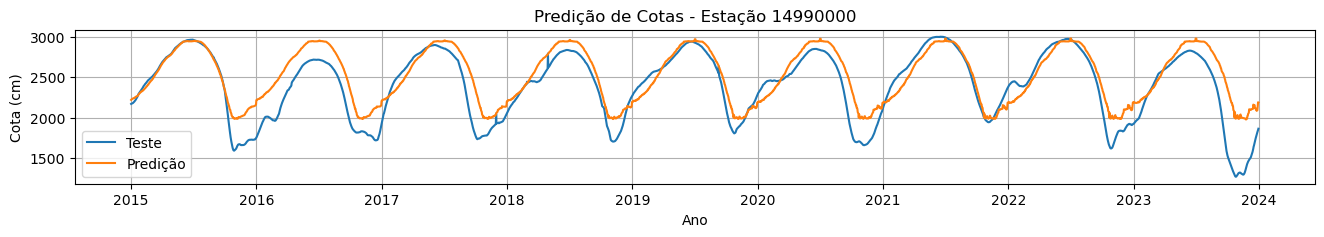

In [12]:
for i, col in enumerate(dados):
    resultado = treinar_modelo(rf, treino[col], teste[col])
    plot_resultado(resultado, teste[col])

### SVR

In [13]:
svr = SVR()

R²: -0.0488, MSE: 26891.0911, RMSE: 163.9850, MAE: 129.9685


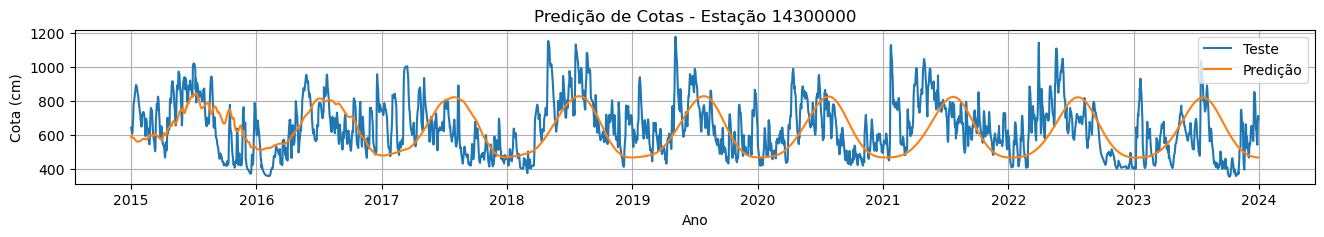

R²: -0.7408, MSE: 43427.4165, RMSE: 208.3925, MAE: 147.0894


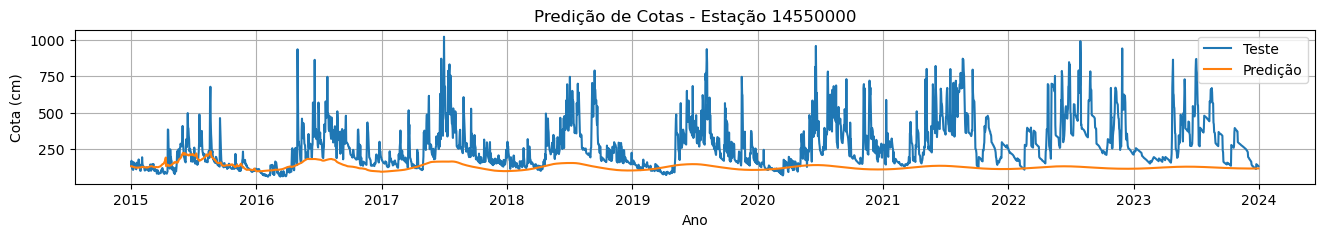

R²: 0.1000, MSE: 19258.0848, RMSE: 138.7735, MAE: 110.7423


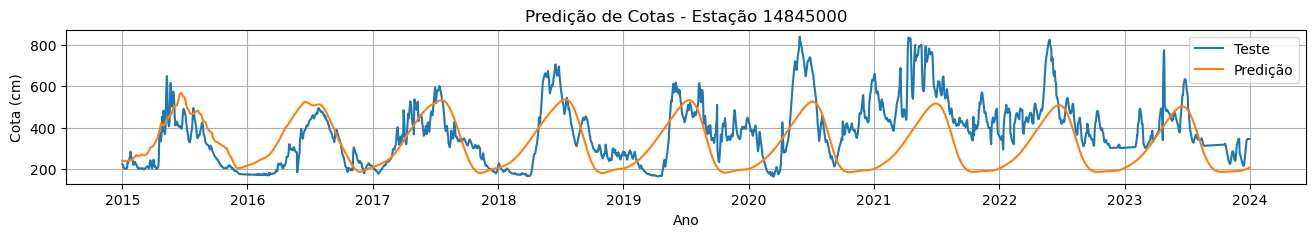

R²: 0.6873, MSE: 55427.4184, RMSE: 235.4303, MAE: 182.8787


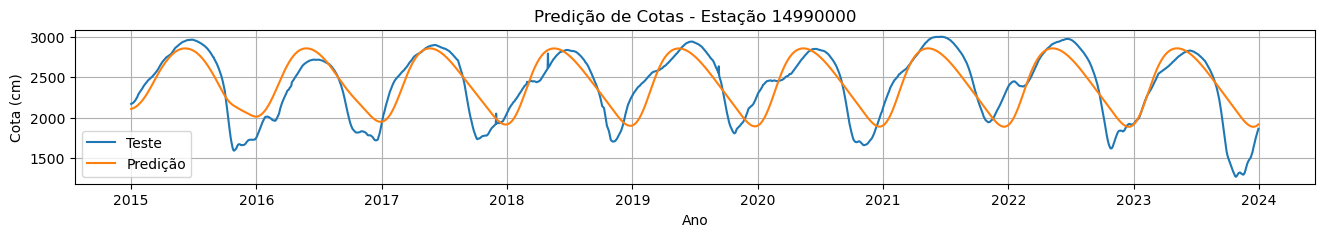

In [14]:
for i, col in enumerate(dados):
    resultado = treinar_modelo(svr, treino[col], teste[col])
    plot_resultado(resultado, teste[col])